In [17]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms,io
import matplotlib.pyplot as plt
from torch import nn

In [18]:
# Setup device-agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [19]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

In [20]:
train_data=datasets.ImageFolder(root=r'C:\Users\Sudip\Desktop\New folder\Data\Train data',transform=data_transform,target_transform=None)
test_data=datasets.ImageFolder(root=r'C:\Users\Sudip\Desktop\New folder\Data\Test data',transform=data_transform)
print(f"Train data:\n{train_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 3753
    Root location: C:\Users\Sudip\Desktop\New folder\Data\Train data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 935
    Root location: C:\Users\Sudip\Desktop\New folder\Data\Test data
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               ToTensor()
           )


In [21]:
class_names=train_data.classes
class_names

['Bandhani', 'Ilkal', 'Kasavu', 'Sambalpuri']

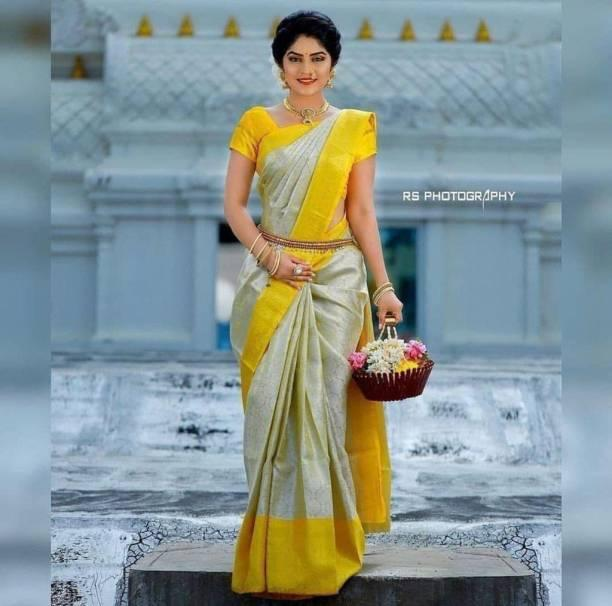

In [22]:
from pathlib import Path
from PIL import Image
import random
N=random.randint(0,500)
img_path=Path(r"C:\Users\Sudip\Desktop\New folder\Data")
img_lst=list(img_path.glob('*/*/*.jpg'))
Image.open(img_lst[N])

(-0.5, 223.5, 223.5, -0.5)

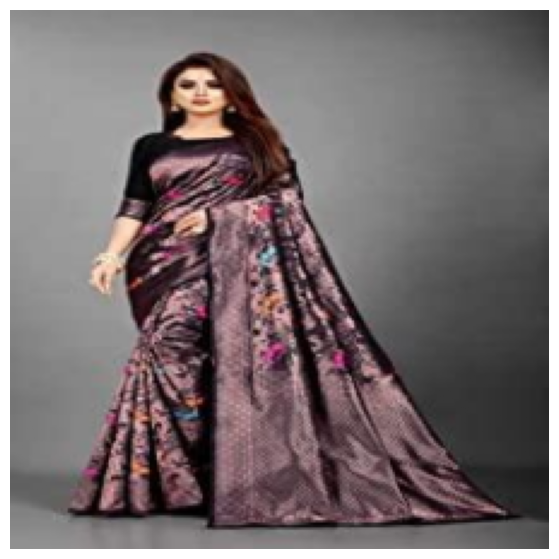

In [23]:
img=test_data[1][0]
img_per=img.permute(1,2,0)
plt.figure(figsize=(10, 7))
plt.imshow(img_per)
plt.axis("off")

In [24]:
# Setup batch size and number of workers 
BATCH_SIZE = 32
print(f"Creating DataLoader's with batch size {BATCH_SIZE} .")

# Create DataLoader's
train_dataloader_simple = DataLoader(train_data, 
                                     batch_size=BATCH_SIZE, 
                                     shuffle=True)

test_dataloader_simple = DataLoader(test_data, 
                                    batch_size=BATCH_SIZE, 
                                    shuffle=False)

train_dataloader_simple, test_dataloader_simple

Creating DataLoader's with batch size 32 .


(<torch.utils.data.dataloader.DataLoader at 0x2521751deb0>,
 <torch.utils.data.dataloader.DataLoader at 0x2521751de80>)

In [25]:
next(iter(train_dataloader_simple))[0].shape

torch.Size([32, 3, 224, 224])

In [36]:
class TinyVGG(nn.Module):
    """
    Model architecture copying TinyVGG from: 
    https://poloclub.github.io/cnn-explainer/
    """
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int) -> None:
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, 
                      out_channels=hidden_units, 
                      kernel_size=3, # how big is the square that's going over the image?
                      stride=1, # default
                      padding=1), # options = "valid" (no padding) or "same" (output has same shape as input) or int for specific number 
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, 
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2) # default stride value is same as kernel_size
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            # Where did this in_features shape come from? 
            # It's because each layer of our network compresses and changes the shape of our inputs data.
            nn.Linear(in_features=hidden_units*56*56,
                      out_features=output_shape)
        )
    
    def forward(self, x: torch.Tensor):
        x = self.conv_block_1(x)
        # print(x.shape)
        x = self.conv_block_2(x)
        # print(x.shape)
        x = self.classifier(x)
        # print(x.shape)
        return x
        # return self.classifier(self.conv_block_2(self.conv_block_1(x))) # <- leverage the benefits of operator fusion


model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0

TinyVGG(
  (conv_block_1): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=31360, out_features=4, bias=True)
  )
)

In [37]:
def train_step(model: torch.nn.Module, 
               dataloader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               optimizer: torch.optim.Optimizer):
    # Put model in train mode
    model.train()
    
    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0
    
    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() 

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch 
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

In [38]:
def test_step(model: torch.nn.Module, 
              dataloader: torch.utils.data.DataLoader, 
              loss_fn: torch.nn.Module):
    # Put model in eval mode
    model.eval() 
    
    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0
    
    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)
            # 1. Forward pass
            test_pred_logits = model(X)

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()
            
            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))
            
    # Adjust metrics to get average loss and accuracy per batch 
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

In [39]:
from tqdm.auto import tqdm

# 1. Take in various parameters required for training and test steps
def train(model: torch.nn.Module, 
          train_dataloader: torch.utils.data.DataLoader, 
          test_dataloader: torch.utils.data.DataLoader, 
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module = nn.CrossEntropyLoss(),
          epochs: int = 5):
    
    # 2. Create empty results dictionary
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    
    # 3. Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                           dataloader=train_dataloader_simple,
                                           loss_fn=loss_fn,
                                           optimizer=optimizer)
        test_loss, test_acc = test_step(model=model,
            dataloader=test_dataloader_simple,
            loss_fn=loss_fn)
        
        # 4. Print out what's happening
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # 6. Return the filled results at the end of the epochs
    return results

In [40]:
# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)
model_0.parameters()

<generator object Module.parameters at 0x000002527BD86C80>

In [41]:
# Set random seeds
torch.manual_seed(42) 
torch.cuda.manual_seed(42)


# Set number of epochs
NUM_EPOCHS = 25

# Recreate an instance of TinyVGG
model_0 = TinyVGG(input_shape=3, # number of color channels (3 for RGB) 
                  hidden_units=10, 
                  output_shape=len(train_data.classes)).to(device)

# Setup loss function and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.001)

# Start the timer
from timeit import default_timer as timer 
start_time = timer()

# Train model_0 
model_0_results = train(model=model_0, 
                        train_dataloader=train_dataloader_simple,
                        test_dataloader=test_dataloader_simple,
                        optimizer=optimizer,
                        loss_fn=loss_fn, 
                        epochs=NUM_EPOCHS)

# End the timer and print out how long it took
end_time = timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")

  0%|          | 0/25 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 0.7466 | train_acc: 0.7214 | test_loss: 0.6077 | test_acc: 0.7927
Epoch: 2 | train_loss: 0.4248 | train_acc: 0.8504 | test_loss: 0.4567 | test_acc: 0.8317
Epoch: 3 | train_loss: 0.2706 | train_acc: 0.9028 | test_loss: 0.4230 | test_acc: 0.8510
Epoch: 4 | train_loss: 0.1820 | train_acc: 0.9375 | test_loss: 0.3934 | test_acc: 0.8750
Epoch: 5 | train_loss: 0.0966 | train_acc: 0.9637 | test_loss: 0.4969 | test_acc: 0.8729
Epoch: 6 | train_loss: 0.0433 | train_acc: 0.9870 | test_loss: 0.5924 | test_acc: 0.8771
Epoch: 7 | train_loss: 0.0208 | train_acc: 0.9958 | test_loss: 0.7162 | test_acc: 0.8625
Epoch: 8 | train_loss: 0.0171 | train_acc: 0.9955 | test_loss: 0.6777 | test_acc: 0.8677
Epoch: 9 | train_loss: 0.0224 | train_acc: 0.9939 | test_loss: 0.6689 | test_acc: 0.8719
Epoch: 10 | train_loss: 0.0108 | train_acc: 0.9966 | test_loss: 0.8061 | test_acc: 0.8844
Epoch: 11 | train_loss: 0.0024 | train_acc: 0.9997 | test_loss: 0.8976 | test_acc: 0.8677
Epoch: 12 | train_l

In [43]:
model_0.state_dict()

OrderedDict([('conv_block_1.0.weight',
              tensor([[[[ 1.5087e-01,  1.8705e-01, -5.5857e-03],
                        [ 1.8692e-01, -9.4303e-03,  8.4768e-02],
                        [-9.8705e-02,  1.2996e-01,  2.0061e-01]],
              
                       [[-1.4104e-01,  1.9550e-01,  7.8835e-02],
                        [ 1.4561e-01,  5.6074e-02,  1.3852e-01],
                        [-4.4765e-02,  1.5598e-01,  5.2308e-02]],
              
                       [[-1.1786e-01,  5.1542e-02, -6.9595e-02],
                        [-4.7011e-02, -7.2838e-02,  1.5127e-01],
                        [-1.9810e-01, -1.0641e-01, -5.2985e-02]]],
              
              
                      [[[-1.0340e-01,  3.1413e-02, -1.8261e-01],
                        [ 1.9567e-01, -1.3878e-01,  1.6677e-01],
                        [ 5.4066e-02, -3.6034e-02,  1.4038e-01]],
              
                       [[ 6.7712e-02,  1.9530e-01,  5.4034e-02],
                        [-1.1623e-02

In [45]:
#saving the state dict
from pathlib import Path
loc1=Path(r'C:\Users\Sudip\Desktop\New folder\models\model_0_TVGG.pth')
torch.save(model_0.state_dict(),loc1)

(-0.5, 63.5, 63.5, -0.5)

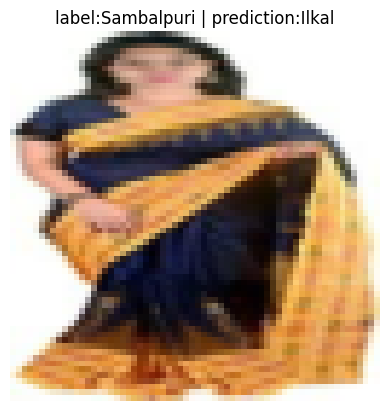

In [ ]:
N=random.randint(0,1000)
Datlod=DataLoader(test_data,1,True)
(X,y)=next(iter(Datlod))
y=y[0]
with torch.inference_mode():
    X=X.to(device)
    y_=model_0(X).argmax()
plt.imshow(X.to('cpu').squeeze().permute(1,2,0))
plt.title(f"label:{class_names[y]} | prediction:{class_names[y_]}")
plt.axis(False)

In [ ]:
X.squeeze().shape

torch.Size([3, 64, 64])

In [ ]:
1+1+4/3+4/3+1+1+1+1+1+1+1+2+2+2+2+2+8/3+2+2+2+2+8/3+2+2+2+2+2+2+2+2+2-100+2

-45.00000000000001